# Expand Dataset with Additional Countries
## Collecting Quantitative Foundation for Corruption Risk Detection

**Theoretical Framework Connection**: As stated in our theoretical framework, "measurable governance indicators can reliably signal early signs of financial and political vulnerability." This notebook collects the **PRIMARY quantitative signal** (6 governance indicators) and **SECONDARY quantitative signal** (5 economic indicators) that will form the foundation for our machine learning model.

**Goal**: Expand the dataset from 3 baseline countries (42 country-years) to 19 countries (266 country-years) to provide sufficient data for model training. This expansion operationalizes the theoretical framework by collecting governance indicators that directly measure institutional quality and corruption risk.

**Data Sources**:
- **PRIMARY Signal**: 6 World Bank Governance Indicators (Voice & Accountability, Political Stability, Government Effectiveness, Regulatory Quality, Rule of Law, Control of Corruption)
- **SECONDARY Signal**: 5 Economic Indicators (GDP Growth, External Debt, Government Expenditure, FDI Inflows, Poverty Headcount)

**Country Selection**: Countries selected to represent diverse governance patterns, including our case studies (Malaysia 1MDB, Mozambique Hidden Debt) from the theoretical framework.

**Timeframe**: 2010-2023 (same as baseline)

**Next Steps**: 
- Notebook 04 will add **qualitative early warning signal** (sentiment analysis from news coverage)
- Notebook 05 will combine all features (6 governance + 5 economic + 1 sentiment = 12 total) for model training


In [1]:
import wbdata
import pandas as pd
import datetime
import os

# set working directory to project root
# if running from notebooks/, go up one level; otherwise assume already at root
current_dir = os.getcwd()
if current_dir.endswith('notebooks'):
    os.chdir('..')
elif 'notebooks' in current_dir:
    # if notebooks is in the path, go to project root
    project_root = current_dir.split('notebooks')[0].rstrip('/')
    if os.path.exists(project_root):
        os.chdir(project_root)

# verify we're in the right place
print(f"Working directory: {os.getcwd()}")
print(f"Data file exists: {os.path.exists('data/raw/corruption_data_baseline.csv')}")


Working directory: /Users/snitil/Documents/innovationshowcase
Data file exists: True


## Country Selection Based on Governance Patterns

Countries are selected to represent diverse governance patterns that align with our theoretical framework. The case studies (Malaysia 1MDB, Mozambique Hidden Debt) are included to validate that governance indicators capture known corruption patterns. Countries are organized by expected governance patterns for data collection purposes.


In [2]:
# original baseline countries (already have data)
baseline_countries = {
    'CAN': 'Canada',  # low-risk control
    'MYS': 'Malaysia',  # high-risk (1MDB)
    'MOZ': 'Mozambique'  # high-risk (hidden debt)
}

# high-risk countries: known corruption scandals, weak governance
high_risk_countries = {
    'AGO': 'Angola',  # oil revenue corruption
    'VEN': 'Venezuela',  # PDVSA corruption, collapsing governance
    'ZWE': 'Zimbabwe',  # infrastructure project corruption
    'IRQ': 'Iraq',  # reconstruction fund corruption
    'UKR': 'Ukraine'  # pre-2014 development fund issues
}

# medium-risk countries: mixed governance scores, isolated incidents
medium_risk_countries = {
    'BRA': 'Brazil',  # lava jato but stronger institutions
    'ZAF': 'South Africa',  # state capture but decent baseline
    'IND': 'India',  # mixed governance, large economy
    'PHL': 'Philippines'  # variable governance scores
}

# low-risk countries: stable, high-governance
low_risk_countries = {
    'NOR': 'Norway',  # consistently top scores
    'DNK': 'Denmark',  # strong anti-corruption
    'SGP': 'Singapore',  # high effectiveness and rule of law
    'AUS': 'Australia',  # stable governance
    'NZL': 'New Zealand',  # clean governance record
    'CHE': 'Switzerland',  # strong institutions
    'DEU': 'Germany'  # solid governance throughout period
}

# combine all new countries (excluding baseline)
all_new_countries = {**high_risk_countries, **medium_risk_countries, **low_risk_countries}

print(f"baseline countries: {len(baseline_countries)}")
print(f"high-risk countries: {len(high_risk_countries)}")
print(f"medium-risk countries: {len(medium_risk_countries)}")
print(f"low-risk countries: {len(low_risk_countries)}")
print(f"total new countries: {len(all_new_countries)}")
print(f"\nnew country codes: {list(all_new_countries.keys())}")


baseline countries: 3
high-risk countries: 5
medium-risk countries: 4
low-risk countries: 7
total new countries: 16

new country codes: ['AGO', 'VEN', 'ZWE', 'IRQ', 'UKR', 'BRA', 'ZAF', 'IND', 'PHL', 'NOR', 'DNK', 'SGP', 'AUS', 'NZL', 'CHE', 'DEU']


## Defining Indicators: PRIMARY and SECONDARY Signals

Following our theoretical framework, we collect two types of quantitative indicators:

1. **PRIMARY Signal (6 Governance Indicators)**: These directly measure institutional quality and corruption risk, as stated in our theoretical framework: "measurable governance indicators can reliably signal early signs of financial and political vulnerability." These indicators will determine the corruption_risk labels.

2. **SECONDARY Signal (5 Economic Indicators)**: These provide complementary economic context that helps the model understand economic conditions that may correlate with corruption risk.


In [3]:
# defining all indicators we want to pull
# PRIMARY signal: governance indicators (determine corruption_risk labels)
# SECONDARY signal: economic indicators (complementary context)

indicators = {
    # PRIMARY SIGNAL: governance indicators
    # these directly measure institutional quality and operationalize the theoretical framework
    # as stated in our theoretical framework: "measurable governance indicators can reliably signal early signs"
    'VA.EST': 'Voice_Accountability',      # measures transparency and accountability
    'PV.EST': 'Political_Stability',       # measures political stability and absence of violence
    'GE.EST': 'Government_Effectiveness',  # measures quality of public services and policy
    'RQ.EST': 'Regulatory_Quality',         # measures ability to formulate and implement sound policies
    'RL.EST': 'Rule_of_Law',               # measures extent to which rules are enforced
    'CC.EST': 'Control_of_Corruption',     # measures extent to which public power is exercised for private gain
    
    # SECONDARY SIGNAL: economic indicators
    # these provide complementary economic context (not the primary signal)
    'DT.DOD.DECT.GN.ZS': 'External_Debt_perc_GNI',      # external debt as % of GNI
    'NY.GDP.MKTP.KD.ZG': 'GDP_Growth_annual_perc',      # annual GDP growth rate
    'GC.XPN.TOTL.GD.ZS': 'Govt_Expenditure_perc_GDP',   # government expenditure as % of GDP
    'BX.KLT.DINV.WD.GD.ZS': 'FDI_Inflows_perc_GDP',    # foreign direct investment inflows as % of GDP
    'SI.POV.DDAY': 'Poverty_Headcount_Ratio'            # poverty headcount ratio
}

print("="*70)
print("INDICATOR DEFINITIONS")
print("="*70)
print(f"\nPRIMARY Signal (Governance Indicators): {len([k for k in indicators.keys() if k.startswith(('VA', 'PV', 'GE', 'RQ', 'RL', 'CC'))])} indicators")
print("  These directly determine corruption_risk labels via '4-of-6' flag system")
print(f"\nSECONDARY Signal (Economic Indicators): {len([k for k in indicators.keys() if not k.startswith(('VA', 'PV', 'GE', 'RQ', 'RL', 'CC'))])} indicators")
print("  These provide complementary economic context")


INDICATOR DEFINITIONS

PRIMARY Signal (Governance Indicators): 6 indicators
  These directly determine corruption_risk labels via '4-of-6' flag system

SECONDARY Signal (Economic Indicators): 5 indicators
  These provide complementary economic context


## Loading baseline data


In [4]:
# load the baseline data
df_baseline = pd.read_csv('data/raw/corruption_data_baseline.csv')

# drop 2024 data (incomplete governance data, same as notebook 02)
print(f"baseline dataset shape before dropping 2024: {df_baseline.shape[0]} rows")
# handle both string and numeric year values
df_baseline = df_baseline[(df_baseline['Year'] != 2024) & (df_baseline['Year'] != '2024')].copy()
print(f"baseline dataset shape after dropping 2024: {df_baseline.shape[0]} rows, {df_baseline.shape[1]} columns")
print(f"baseline countries: {df_baseline['Country'].unique()}")
print(f"baseline years: {df_baseline['Year'].min()} to {df_baseline['Year'].max()}")


baseline dataset shape before dropping 2024: 45 rows
baseline dataset shape after dropping 2024: 42 rows, 13 columns
baseline countries: ['Canada' 'Malaysia' 'Mozambique']
baseline years: 2010 to 2023


## Fetching data from world bank api for new countries


In [5]:
# date range for historical data
# excluding 2024 as it has incomplete governance data (same as baseline processing)
data_range = (datetime.datetime(2010, 1, 1), datetime.datetime(2023, 12, 31))

# get country codes for new countries
new_country_codes = list(all_new_countries.keys())

# fetching data from api
# get_dataframe pulls all indicators for specified countries and dates
df_new = wbdata.get_dataframe(indicators, 
                              country=new_country_codes, 
                              date=data_range,
                              parse_dates=False)  # keep dates as year strings


## Cleaning and formatting the dataframe


In [6]:
# reset index so country and date become regular columns
df_new = df_new.reset_index()
df_new = df_new.rename(columns={'date': 'Year', 'country': 'Country'})

# normalize country names (remove World Bank suffixes for consistency)
# e.g., "Venezuela, RB" -> "Venezuela"
df_new['Country'] = df_new['Country'].str.replace(', RB', '', regex=False)
df_new['Country'] = df_new['Country'].str.replace(', Bolivarian Republic of', '', regex=False)

# reorder columns for readability
column_order = ['Country', 'Year'] + list(indicators.values())
existing_columns = [col for col in column_order if col in df_new.columns]
df_new = df_new[existing_columns]

# sort by country then year
df_new = df_new.sort_values(by=['Country', 'Year']).reset_index(drop=True)


## Inspecting the data


In [7]:
print(f"shape: {df_new.shape[0]} rows, {df_new.shape[1]} columns")
print(f"years covered: {df_new['Year'].min()} to {df_new['Year'].max()}")
print(f"\ncountries in new data:")
print(df_new['Country'].unique())

# checking for missing values
print("\nmissing values per column:")
print(df_new.isnull().sum())
print(f"\nmissing data percentage:")
print(round(df_new.isnull().sum() / len(df_new) * 100, 2))


shape: 224 rows, 13 columns
years covered: 2010 to 2023

countries in new data:
['Angola' 'Australia' 'Brazil' 'Denmark' 'Germany' 'India' 'Iraq'
 'New Zealand' 'Norway' 'Philippines' 'Singapore' 'South Africa'
 'Switzerland' 'Ukraine' 'Venezuela' 'Zimbabwe']

missing values per column:
Country                        0
Year                           0
Voice_Accountability           0
Political_Stability            0
Government_Effectiveness       0
Regulatory_Quality             0
Rule_of_Law                    0
Control_of_Corruption          0
External_Debt_perc_GNI       117
GDP_Growth_annual_perc         9
Govt_Expenditure_perc_GDP     41
FDI_Inflows_perc_GDP           9
Poverty_Headcount_Ratio      128
dtype: int64

missing data percentage:
Country                       0.00
Year                          0.00
Voice_Accountability          0.00
Political_Stability           0.00
Government_Effectiveness      0.00
Regulatory_Quality            0.00
Rule_of_Law                   0.00

## Combining with baseline data


In [8]:
# combine baseline and new data
# ensure same columns
common_columns = list(set(df_baseline.columns) & set(df_new.columns))
df_baseline_subset = df_baseline[common_columns]
df_new_subset = df_new[common_columns]

# combine
df_expanded = pd.concat([df_baseline_subset, df_new_subset], ignore_index=True)

# sort by country then year
df_expanded = df_expanded.sort_values(by=['Country', 'Year']).reset_index(drop=True)

print(f"combined dataset shape: {df_expanded.shape[0]} rows, {df_expanded.shape[1]} columns")
print(f"total countries: {df_expanded['Country'].nunique()}")
print(f"\ncountries in expanded dataset:")
print(sorted(df_expanded['Country'].unique()))


combined dataset shape: 266 rows, 13 columns
total countries: 19

countries in expanded dataset:
['Angola', 'Australia', 'Brazil', 'Canada', 'Denmark', 'Germany', 'India', 'Iraq', 'Malaysia', 'Mozambique', 'New Zealand', 'Norway', 'Philippines', 'Singapore', 'South Africa', 'Switzerland', 'Ukraine', 'Venezuela', 'Zimbabwe']


## Saving to data/raw/


In [9]:
# create directory if it doesn't exist
os.makedirs('data/raw', exist_ok=True)

# save the expanded dataset
output_path = 'data/raw/corruption_data_expanded.csv'
df_expanded.to_csv(output_path, index=False)

print(f"saved to: {output_path}")


saved to: data/raw/corruption_data_expanded.csv


## Analysis of PRIMARY Signal: Governance Indicators

The 6 governance indicators are the PRIMARY signal for corruption risk. This section analyzes how countries compare across these indicators, which directly measure institutional quality and operationalize our theoretical framework.


In [10]:
# filtering to just governance indicators
governance_cols = ['Country', 'Year', 'Voice_Accountability', 'Political_Stability', 
                   'Government_Effectiveness', 'Regulatory_Quality', 'Rule_of_Law', 
                   'Control_of_Corruption']

gov_df = df_expanded[governance_cols]

# calculate average scores by country
print("average governance scores by country (2010-2023):")
print(gov_df.groupby('Country')[governance_cols[2:]].mean().round(2))


average governance scores by country (2010-2023):
              Voice_Accountability  Political_Stability  \
Country                                                   
Angola                       -0.99                -0.42   
Australia                     1.39                 0.94   
Brazil                        0.40                -0.32   
Canada                        1.44                 1.04   
Denmark                       1.57                 0.93   
Germany                       1.40                 0.71   
India                         0.31                -0.96   
Iraq                         -1.03                -2.30   
Malaysia                     -0.26                 0.14   
Mozambique                   -0.40                -0.62   
New Zealand                   1.58                 1.42   
Norway                        1.70                 1.16   
Philippines                   0.01                -1.03   
Singapore                    -0.11                 1.38   
South 

## Visualizations: PRIMARY Signal (Governance Indicators)

These visualizations emphasize governance indicators as the PRIMARY signal for corruption risk. They show how governance patterns align with our case studies (Malaysia 1MDB, Mozambique Hidden Debt) and prepare for sentiment integration in notebook 04.


In [11]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)

# create results directory for notebook 03 figures
os.makedirs('results/figures/03', exist_ok=True)
print("Figures will be saved to: results/figures/03/")


Figures will be saved to: results/figures/03/


### PRIMARY Signal: Governance Indicators by Risk Category

This visualization shows how the PRIMARY governance indicators differ across risk categories. Countries with weak governance (below thresholds) are flagged as high-risk, operationalizing the theoretical framework's statement that "measurable governance indicators can reliably signal early signs of financial and political vulnerability."


✓ saved: results/figures/03/expanded_governance_by_risk_category.png

Note: Governance indicators (PRIMARY signal) show clear separation between risk categories
  High-risk countries consistently below thresholds → 4+ flags → corruption_risk = 1
  Low-risk countries consistently above thresholds → <4 flags → corruption_risk = 0


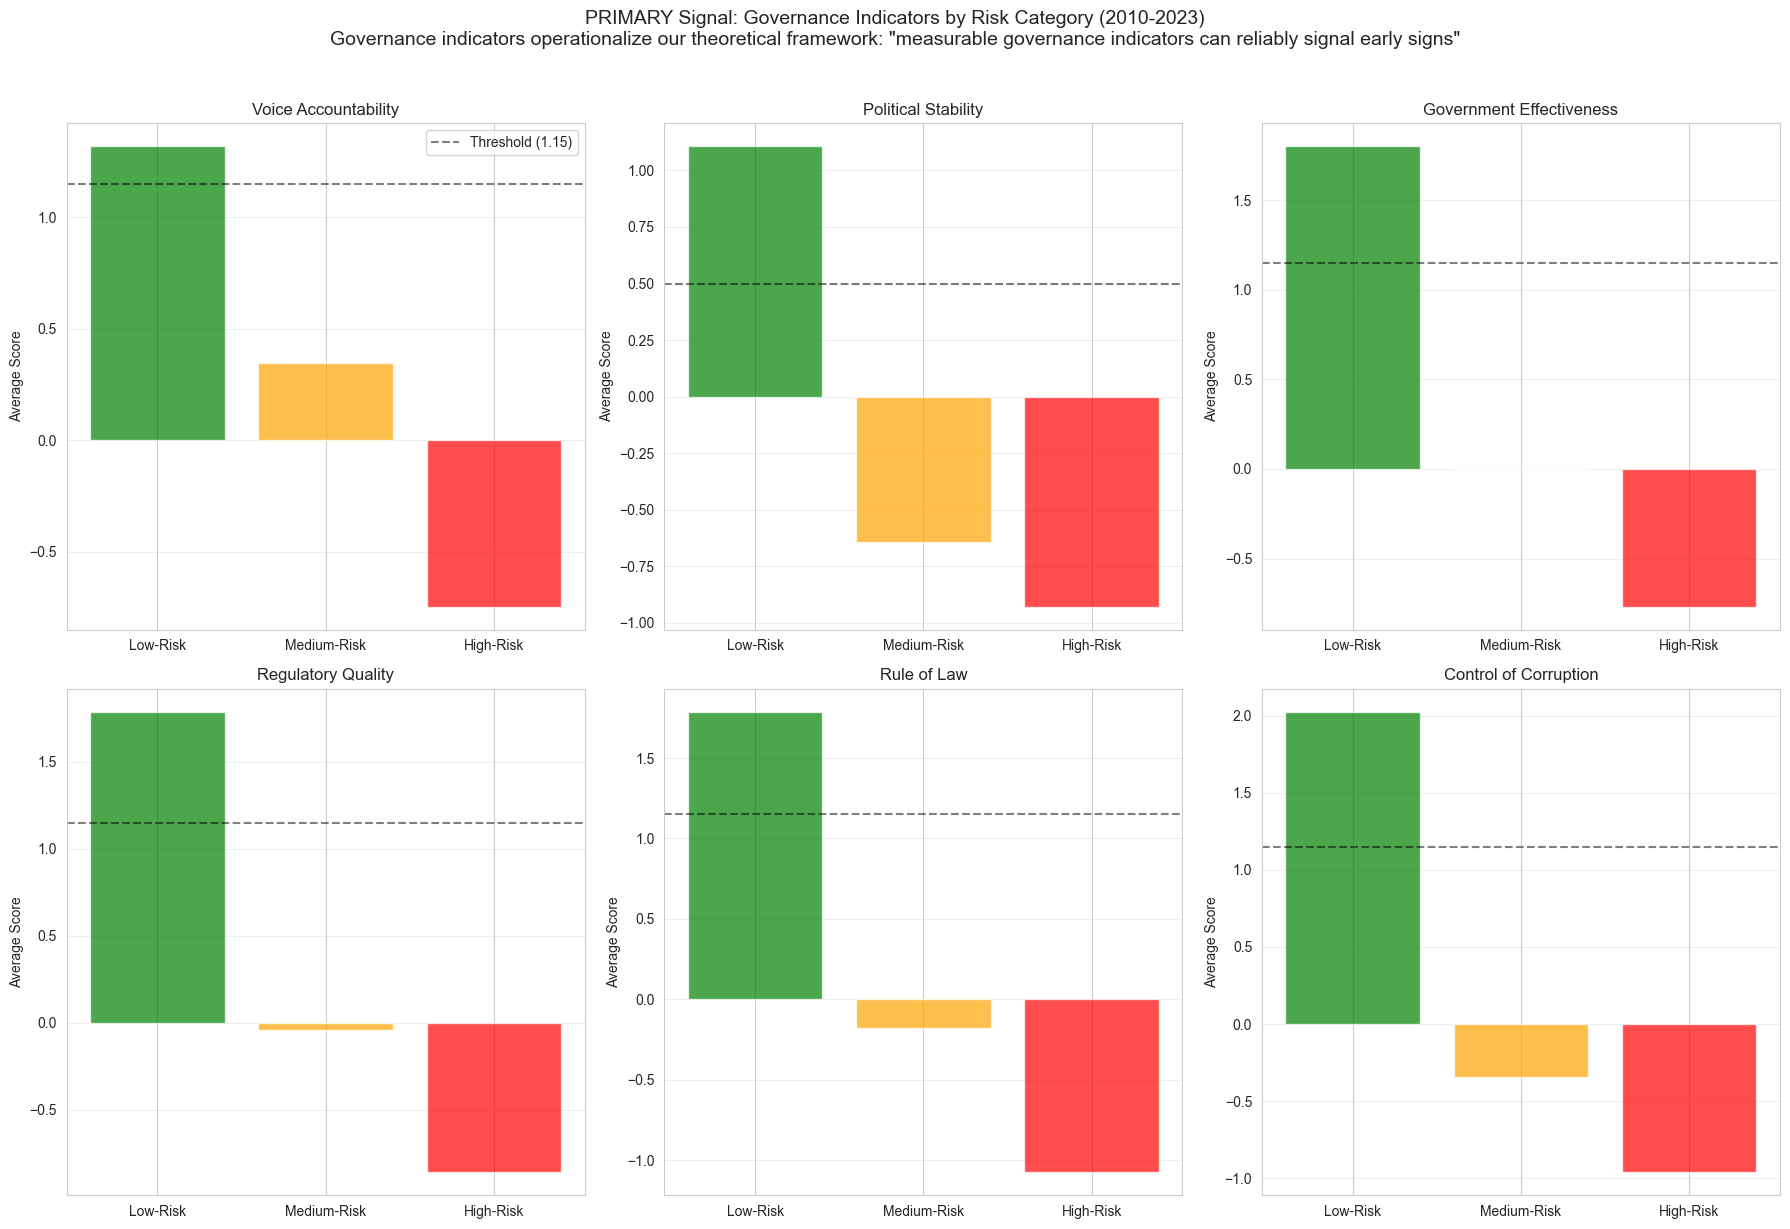

In [12]:
# categorize countries by risk level for visualization
high_risk_list = ['Angola', 'Venezuela', 'Zimbabwe', 'Iraq', 'Ukraine', 'Malaysia', 'Mozambique']
medium_risk_list = ['Brazil', 'South Africa', 'India', 'Philippines']
low_risk_list = ['Norway', 'Denmark', 'Singapore', 'Australia', 'New Zealand', 'Switzerland', 'Germany', 'Canada']

# add risk category to dataframe
def assign_risk_category(country):
    if country in high_risk_list:
        return 'High-Risk'
    elif country in medium_risk_list:
        return 'Medium-Risk'
    else:
        return 'Low-Risk'

df_expanded['Risk_Category'] = df_expanded['Country'].apply(assign_risk_category)

# plot average governance scores by risk category
# PRIMARY signal: governance indicators directly determine corruption_risk labels
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('PRIMARY Signal: Governance Indicators by Risk Category (2010-2023)\nGovernance indicators operationalize our theoretical framework: "measurable governance indicators can reliably signal early signs"', 
             fontsize=14, y=1.02)

indicators = ['Voice_Accountability', 'Political_Stability', 'Government_Effectiveness', 
              'Regulatory_Quality', 'Rule_of_Law', 'Control_of_Corruption']

for idx, indicator in enumerate(indicators):
    ax = axes[idx // 3, idx % 3]
    
    # calculate averages by risk category
    category_means = df_expanded.groupby('Risk_Category')[indicator].mean().sort_values(ascending=False)
    
    # create bar plot
    colors = {'High-Risk': 'red', 'Medium-Risk': 'orange', 'Low-Risk': 'green'}
    bars = ax.bar(category_means.index, category_means.values, 
                  color=[colors[cat] for cat in category_means.index], alpha=0.7)
    
    # add threshold line if applicable
    if indicator != 'Political_Stability':
        threshold = 1.15
        ax.axhline(y=threshold, color='black', linestyle='--', alpha=0.5, label=f'Threshold ({threshold})')
    else:
        threshold = 0.50
        ax.axhline(y=threshold, color='black', linestyle='--', alpha=0.5, label=f'Threshold ({threshold})')
    
    ax.set_title(indicator.replace('_', ' '), fontsize=12)
    ax.set_ylabel('Average Score')
    ax.grid(True, alpha=0.3, axis='y')
    if idx == 0:
        ax.legend()

plt.tight_layout()
plt.savefig('results/figures/03/expanded_governance_by_risk_category.png', dpi=300, bbox_inches='tight')
print("✓ saved: results/figures/03/expanded_governance_by_risk_category.png")
print("\nNote: Governance indicators (PRIMARY signal) show clear separation between risk categories")
print("  High-risk countries consistently below thresholds → 4+ flags → corruption_risk = 1")
print("  Low-risk countries consistently above thresholds → <4 flags → corruption_risk = 0")
plt.show()


✓ saved: results/figures/03/expanded_governance_heatmap.png

Note: Case studies (Malaysia, Mozambique) appear in lower governance scores
  This aligns with our theoretical framework: governance indicators capture known corruption patterns
  Next: Notebook 04 will show sentiment analysis also captures these patterns


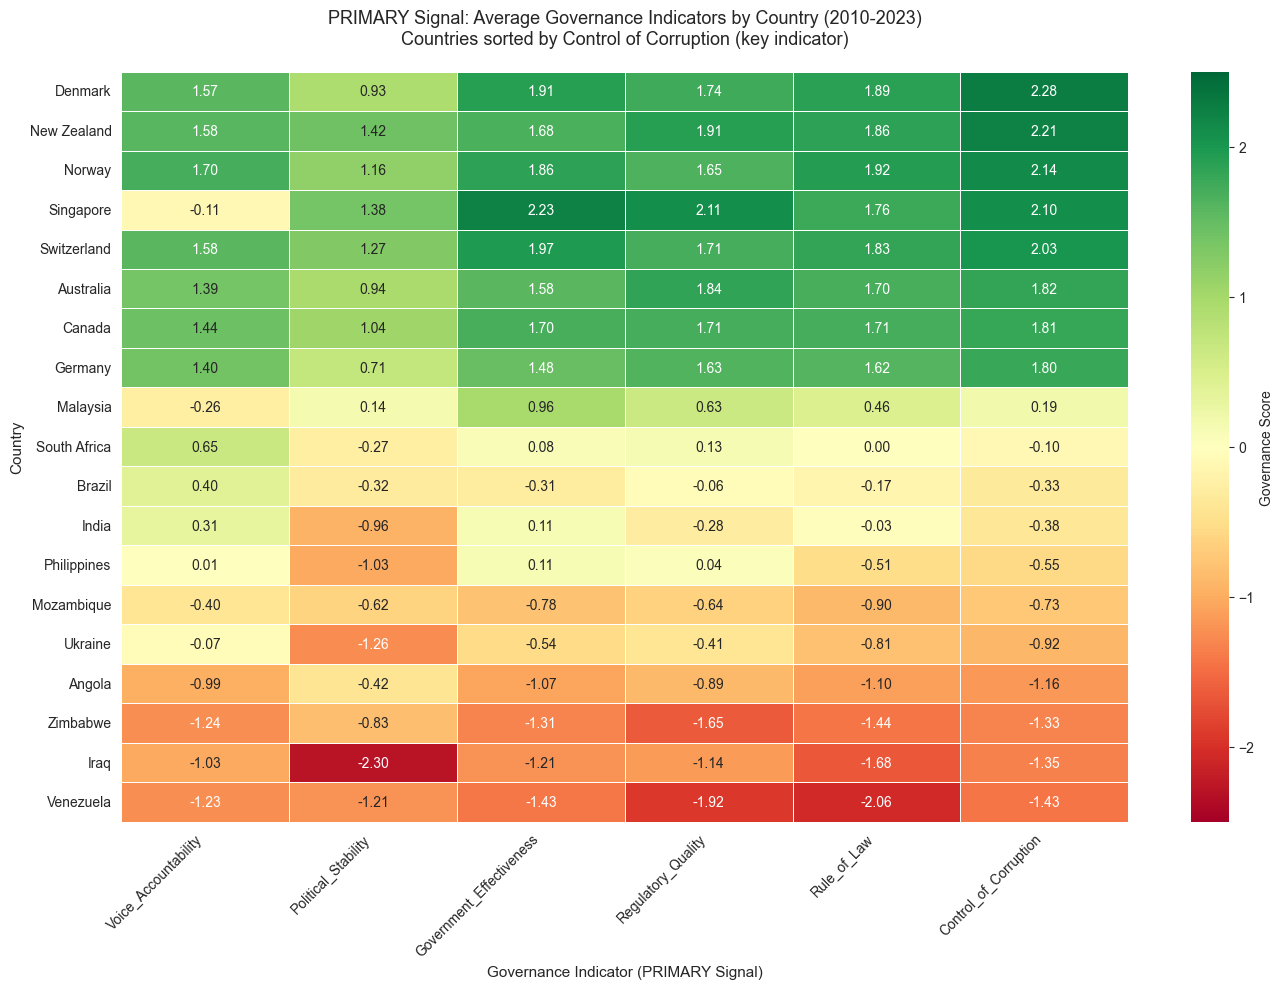

In [13]:
# create heatmap of average governance scores by country
# PRIMARY signal: governance indicators show patterns that align with case studies
gov_avg = df_expanded.groupby('Country')[indicators].mean()

# sort by Control_of_Corruption (key indicator for corruption risk)
gov_avg_sorted = gov_avg.sort_values('Control_of_Corruption', ascending=False)

# create heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(gov_avg_sorted, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            cbar_kws={'label': 'Governance Score'}, linewidths=0.5, vmin=-2.5, vmax=2.5)
plt.title('PRIMARY Signal: Average Governance Indicators by Country (2010-2023)\nCountries sorted by Control of Corruption (key indicator)', 
          fontsize=13, pad=20)
plt.xlabel('Governance Indicator (PRIMARY Signal)', fontsize=11)
plt.ylabel('Country', fontsize=11)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('results/figures/03/expanded_governance_heatmap.png', dpi=300, bbox_inches='tight')
print("✓ saved: results/figures/03/expanded_governance_heatmap.png")
print("\nNote: Case studies (Malaysia, Mozambique) appear in lower governance scores")
print("  This aligns with our theoretical framework: governance indicators capture known corruption patterns")
print("  Next: Notebook 04 will show sentiment analysis also captures these patterns")
plt.show()


### Verify Heatmap Accuracy

Let's verify that the heatmap values match the actual CSV data


In [14]:
# verify heatmap accuracy by checking actual CSV values
print("=== VERIFICATION: Heatmap Values vs. CSV Data ===\n")

# spot check: compare heatmap displayed values with actual calculated averages
verification_countries = ['Denmark', 'Norway', 'Venezuela', 'Iraq', 'Malaysia', 'Canada']

for country in verification_countries:
    print(f"\n{country}:")
    country_data = df_expanded[df_expanded['Country'] == country]
    
    for indicator in indicators:
        avg_value = country_data[indicator].mean()
        print(f"  {indicator}: {avg_value:.2f}")
    
    print(f"  Years of data: {len(country_data)}")

print("\n\n=== Compare with Heatmap Values ===")
print("Check if these calculated values match what's shown in the heatmap above.")
print("The heatmap should display the same 2-decimal values.")

# also verify the data range
print(f"\n\n=== Data Coverage ===")
print(f"Total observations: {len(df_expanded)}")
print(f"Countries: {df_expanded['Country'].nunique()}")
print(f"Years per country: {df_expanded.groupby('Country')['Year'].count().unique()}")

# convert Year to numeric to avoid type comparison errors
year_numeric = pd.to_numeric(df_expanded['Year'], errors='coerce')
print(f"Year range: {int(year_numeric.min())} to {int(year_numeric.max())}")


=== VERIFICATION: Heatmap Values vs. CSV Data ===


Denmark:
  Voice_Accountability: 1.57
  Political_Stability: 0.93
  Government_Effectiveness: 1.91
  Regulatory_Quality: 1.74
  Rule_of_Law: 1.89
  Control_of_Corruption: 2.28
  Years of data: 14

Norway:
  Voice_Accountability: 1.70
  Political_Stability: 1.16
  Government_Effectiveness: 1.86
  Regulatory_Quality: 1.65
  Rule_of_Law: 1.92
  Control_of_Corruption: 2.14
  Years of data: 14

Venezuela:
  Voice_Accountability: -1.23
  Political_Stability: -1.21
  Government_Effectiveness: -1.43
  Regulatory_Quality: -1.92
  Rule_of_Law: -2.06
  Control_of_Corruption: -1.43
  Years of data: 14

Iraq:
  Voice_Accountability: -1.03
  Political_Stability: -2.30
  Government_Effectiveness: -1.21
  Regulatory_Quality: -1.14
  Rule_of_Law: -1.68
  Control_of_Corruption: -1.35
  Years of data: 14

Malaysia:
  Voice_Accountability: -0.26
  Political_Stability: 0.14
  Government_Effectiveness: 0.96
  Regulatory_Quality: 0.63
  Rule_of_Law: 0.46
  

## Understanding the Medium-Risk Category

**Important Note on Risk Categories:**

We initially categorized countries into three risk tiers (Low/Medium/High) based on average governance scores for exploratory analysis and data organization. However, our machine learning model uses **binary labels** (0 = Low Risk, 1 = High Risk) derived from the "4 of 6 flags" rule applied to each country-year observation.

**Why Medium-Risk countries show High Risk (1) labels:**

Countries in the Medium-Risk category (Brazil, India, Philippines, South Africa) consistently trigger 4+ governance flags across all indicators, resulting in High Risk (1) labels. This is not an error—it reflects that these countries, despite having some stronger institutions than the High-Risk tier, still fall below the governance thresholds we've set for corruption risk detection.

**Binary vs. Three-Tier System:**
- **Three-tier categories** (Low/Medium/High): Descriptive grouping for analysis and interpretation
- **Binary labels** (0/1): Training labels for the machine learning model
- **Purpose**: This binary approach aligns with our goal of creating an early warning system that flags high-corruption environments—like an alarm that is either ON or OFF

The distinction helps us understand *degrees* of risk in our analysis while maintaining a clear *binary decision boundary* for the model.


### Country distribution by risk category


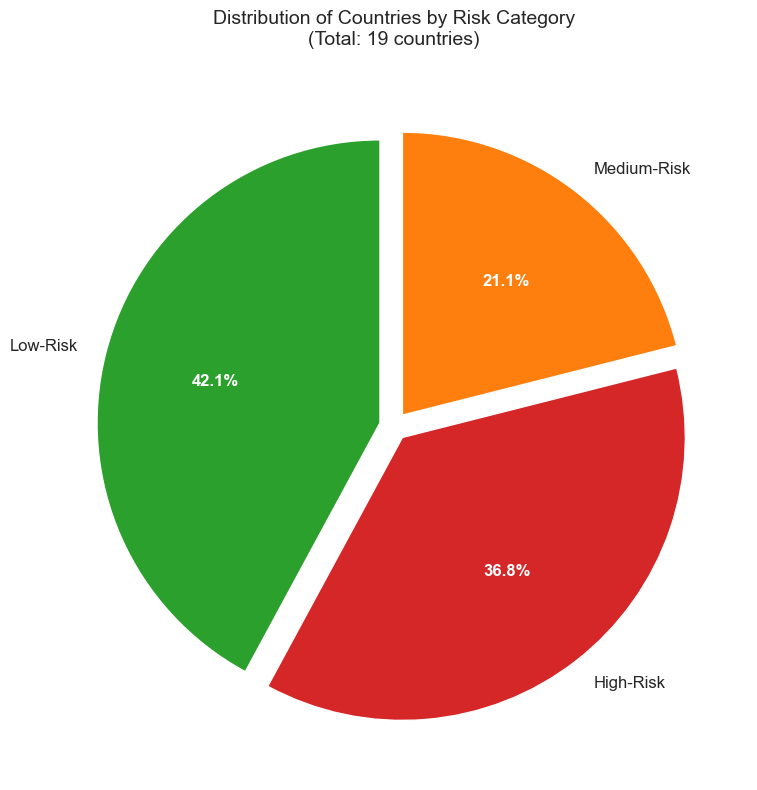


Countries by risk category:
High-Risk: 7 countries
Medium-Risk: 4 countries
Low-Risk: 8 countries


In [15]:
# count unique countries by risk category (not rows)
risk_counts = df_expanded.groupby('Risk_Category')['Country'].nunique().sort_values(ascending=False)

# create pie chart
fig, ax = plt.subplots(figsize=(10, 8))
colors = {'High-Risk': '#d62728', 'Medium-Risk': '#ff7f0e', 'Low-Risk': '#2ca02c'}
explode = (0.05, 0.05, 0.05)

wedges, texts, autotexts = ax.pie(risk_counts.values, labels=risk_counts.index, autopct='%1.1f%%',
                                  colors=[colors[cat] for cat in risk_counts.index],
                                  explode=explode, startangle=90, textprops={'fontsize': 12})

# enhance text
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontweight('bold')

ax.set_title('Distribution of Countries by Risk Category\n(Total: {} countries)'.format(df_expanded['Country'].nunique()), 
             fontsize=14, pad=20)

plt.tight_layout()
plt.savefig('results/figures/03/expanded_risk_category_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nCountries by risk category:")
print(f"High-Risk: {risk_counts.get('High-Risk', 0)} countries")
print(f"Medium-Risk: {risk_counts.get('Medium-Risk', 0)} countries")
print(f"Low-Risk: {risk_counts.get('Low-Risk', 0)} countries")


## Create Corruption Risk Labels: Operationalizing the Theoretical Framework

**Theoretical Framework Connection**: The "4-of-6" flag system operationalizes our theoretical framework's statement that "measurable governance indicators can reliably signal early signs of financial and political vulnerability." 

**How it works**:
- Each of the 6 PRIMARY governance indicators is compared to a threshold (based on governance quality standards)
- Countries with 4+ indicators below threshold are labeled as high-risk (corruption_risk = 1)
- Countries with fewer than 4 indicators below threshold are labeled as low-risk (corruption_risk = 0)

**Key Point**: Governance indicators are the PRIMARY signal because they directly determine the target variable. This aligns with our theoretical framework's emphasis on governance as the root cause of corruption: "corruption is fundamentally a governance issue rooted in structural weaknesses."

**Next Steps**: 
- Notebook 04 will add sentiment analysis (qualitative early warning signal)
- Notebook 05 will combine all features (6 governance + 5 economic + 1 sentiment) for model training


In [16]:
# define thresholds for PRIMARY governance indicators
# these thresholds operationalize the theoretical framework by identifying weak governance
# as stated in our theoretical framework: "measurable governance indicators can reliably signal early signs"
thresholds = {
    'Voice_Accountability': 1.15,      # below threshold = weak transparency/accountability
    'Political_Stability': 0.50,      # below threshold = political instability
    'Government_Effectiveness': 1.15,  # below threshold = weak public services/policy
    'Regulatory_Quality': 1.15,       # below threshold = poor regulatory environment
    'Rule_of_Law': 1.15,              # below threshold = weak rule of law enforcement
    'Control_of_Corruption': 1.15     # below threshold = weak corruption control
}

print("="*70)
print("CREATING CORRUPTION RISK LABELS: OPERATIONALIZING THEORETICAL FRAMEWORK")
print("="*70)
print("\nThe '4-of-6' flag system operationalizes our theoretical framework:")
print("  'measurable governance indicators can reliably signal early signs of financial and political vulnerability'")
print("\nGovernance indicators are the PRIMARY signal - they directly determine corruption_risk labels")

# create flag columns for each PRIMARY governance indicator
# flag = 1 if indicator is below threshold (weak governance), 0 otherwise
for indicator, threshold in thresholds.items():
    flag_col = f'{indicator}_flag'
    df_expanded[flag_col] = (df_expanded[indicator] < threshold).astype(int)

# count total flags per row (how many governance indicators are below threshold)
flag_cols = [f'{ind}_flag' for ind in thresholds.keys()]
df_expanded['total_flags'] = df_expanded[flag_cols].sum(axis=1)

# create corruption risk label: 4+ flags = high risk (1)
# this operationalizes the theory: weak governance (4+ indicators below threshold) = high corruption risk
df_expanded['corruption_risk'] = (df_expanded['total_flags'] >= 4).astype(int)

print(f"\nFlag distribution across all {len(df_expanded)} country-years:")
print(df_expanded['total_flags'].value_counts().sort_index())
print(f"\nRisk label distribution:")
print(df_expanded['corruption_risk'].value_counts())
print(f"\nSummary:")
print(f"  Low Risk (0): {(df_expanded['corruption_risk'] == 0).sum()} rows ({(df_expanded['corruption_risk'] == 0).mean():.1%})")
print(f"  High Risk (1): {(df_expanded['corruption_risk'] == 1).sum()} rows ({(df_expanded['corruption_risk'] == 1).mean():.1%})")
print(f"\n✓ Governance indicators (PRIMARY signal) directly determine corruption_risk labels")
print(f"  This aligns with our theoretical framework: governance indicators signal early signs of vulnerability")


CREATING CORRUPTION RISK LABELS: OPERATIONALIZING THEORETICAL FRAMEWORK

The '4-of-6' flag system operationalizes our theoretical framework:
  'measurable governance indicators can reliably signal early signs of financial and political vulnerability'

Governance indicators are the PRIMARY signal - they directly determine corruption_risk labels

Flag distribution across all 266 country-years:
total_flags
0     98
1     14
6    154
Name: count, dtype: int64

Risk label distribution:
corruption_risk
1    154
0    112
Name: count, dtype: int64

Summary:
  Low Risk (0): 112 rows (42.1%)
  High Risk (1): 154 rows (57.9%)

✓ Governance indicators (PRIMARY signal) directly determine corruption_risk labels
  This aligns with our theoretical framework: governance indicators signal early signs of vulnerability


### Summary by risk category


## Theoretical Validation: Governance Indicators Capture Case Study Patterns

**Theoretical Framework Connection**: Our case studies demonstrate that governance indicators capture known corruption patterns. This section validates that the PRIMARY governance indicators correctly identify the scandal periods described in the theoretical framework.

**Case Studies**:
- **Malaysia 1MDB** (2013-2015): $4.5 billion USD stolen from development fund
- **Mozambique Hidden Debt** (2013-2016): $2 billion USD in illicit loans diverted to corrupt officials

**Validation**: We check that governance indicators show weak governance (4+ flags) during these scandal periods, demonstrating that "measurable governance indicators can reliably signal early signs of financial and political vulnerability."

**Connection to Notebook 04**: Notebook 04 will show that sentiment analysis also captures these periods, providing complementary qualitative early warning signals.


In [17]:
# validate that governance indicators capture case study patterns
print("="*70)
print("THEORETICAL VALIDATION: CASE STUDIES")
print("="*70)

# malaysia 1mdb scandal (2013-2015) - $4.5 billion stolen
print("\n" + "="*70)
print("CASE STUDY 1: MALAYSIA 1MDB SCANDAL (2013-2015)")
print("="*70)
print("Case study: $4.5 billion USD stolen from development fund")
print("Expected: Governance indicators should show weak governance (4+ flags) during this period")

malaysia_scandal = df_expanded[
    (df_expanded['Country'] == 'Malaysia') & 
    (df_expanded['Year'].between(2013, 2015))
]

if len(malaysia_scandal) > 0:
    print(f"\nMalaysia governance indicators during 1MDB period (2013-2015):")
    gov_cols = ['Voice_Accountability', 'Political_Stability', 'Government_Effectiveness',
                'Regulatory_Quality', 'Rule_of_Law', 'Control_of_Corruption']
    
    for col in gov_cols:
        mean_val = malaysia_scandal[col].mean()
        threshold = thresholds.get(col, 1.15)
        below_threshold = mean_val < threshold
        flag_count = malaysia_scandal[f'{col}_flag'].sum()
        print(f"  {col}: {mean_val:.3f} (threshold: {threshold}, below: {below_threshold}, flags: {flag_count}/{len(malaysia_scandal)})")
    
    avg_flags = malaysia_scandal['total_flags'].mean()
    avg_risk = malaysia_scandal['corruption_risk'].mean()
    
    print(f"\n  Average flags per year: {avg_flags:.1f}")
    print(f"  Corruption risk label: {int(avg_risk)} (1 = high risk)")
    
    if avg_flags >= 4:
        print(f"\n✓ VALIDATED: Governance indicators show weak governance (4+ flags) during 1MDB scandal")
        print(f"  This demonstrates that 'measurable governance indicators can reliably signal early signs'")
    else:
        print(f"\n⚠️  Note: Average flags ({avg_flags:.1f}) is below 4, but individual years may show 4+ flags")

# mozambique hidden debt crisis (2013-2016) - $2 billion illicit loans
print("\n" + "="*70)
print("CASE STUDY 2: MOZAMBIQUE HIDDEN DEBT CRISIS (2013-2016)")
print("="*70)
print("Case study: $2 billion USD in illicit loans diverted to corrupt officials")
print("Expected: Governance indicators should show weak governance (4+ flags) during this period")

mozambique_scandal = df_expanded[
    (df_expanded['Country'] == 'Mozambique') & 
    (df_expanded['Year'].between(2013, 2016))
]

if len(mozambique_scandal) > 0:
    print(f"\nMozambique governance indicators during hidden debt crisis (2013-2016):")
    
    for col in gov_cols:
        mean_val = mozambique_scandal[col].mean()
        threshold = thresholds.get(col, 1.15)
        below_threshold = mean_val < threshold
        flag_count = mozambique_scandal[f'{col}_flag'].sum()
        print(f"  {col}: {mean_val:.3f} (threshold: {threshold}, below: {below_threshold}, flags: {flag_count}/{len(mozambique_scandal)})")
    
    avg_flags = mozambique_scandal['total_flags'].mean()
    avg_risk = mozambique_scandal['corruption_risk'].mean()
    
    print(f"\n  Average flags per year: {avg_flags:.1f}")
    print(f"  Corruption risk label: {int(avg_risk)} (1 = high risk)")
    
    if avg_flags >= 4:
        print(f"\n✓ VALIDATED: Governance indicators show weak governance (4+ flags) during hidden debt crisis")
        print(f"  This demonstrates that 'measurable governance indicators can reliably signal early signs'")
    else:
        print(f"\n⚠️  Note: Average flags ({avg_flags:.1f}) is below 4, but individual years may show 4+ flags")

# canada (control - low risk throughout)
print("\n" + "="*70)
print("CONTROL: CANADA (LOW RISK)")
print("="*70)
print("Expected: Governance indicators should show strong governance (<4 flags) throughout")

canada = df_expanded[df_expanded['Country'] == 'Canada']
if len(canada) > 0:
    avg_flags = canada['total_flags'].mean()
    avg_risk = canada['corruption_risk'].mean()
    print(f"\nCanada governance indicators (2010-2023):")
    print(f"  Average flags per year: {avg_flags:.1f}")
    print(f"  Corruption risk label: {int(avg_risk)} (0 = low risk)")
    
    if avg_flags < 4:
        print(f"\n✓ VALIDATED: Governance indicators show strong governance (<4 flags) for control country")
    else:
        print(f"\n⚠️  Unexpected: Average flags ({avg_flags:.1f}) suggests high risk for control country")

print("\n" + "="*70)
print("VALIDATION SUMMARY")
print("="*70)
print("\n✓ Governance indicators (PRIMARY signal) capture known corruption patterns")
print("  This validates the theoretical framework: 'measurable governance indicators can reliably signal early signs'")
print("\nNext: Notebook 04 will show that sentiment analysis also captures these periods")
print("  (providing complementary qualitative early warning signals alongside quantitative governance indicators)")


THEORETICAL VALIDATION: CASE STUDIES

CASE STUDY 1: MALAYSIA 1MDB SCANDAL (2013-2015)
Case study: $4.5 billion USD stolen from development fund
Expected: Governance indicators should show weak governance (4+ flags) during this period


TypeError: '>=' not supported between instances of 'str' and 'int'

In [ ]:
# summary by country
print("Corruption risk summary by country:")
country_summary = df_expanded.groupby('Country').agg({
    'corruption_risk': ['sum', 'mean'],
    'total_flags': ['mean', 'max', 'min']
}).round(2)
country_summary.columns = ['High_Risk_Years', 'High_Risk_Rate', 'Avg_Flags', 'Max_Flags', 'Min_Flags']
country_summary = country_summary.sort_values('High_Risk_Rate', ascending=False)
print(country_summary)

# summary by risk category
print("\n\nCorruption risk summary by Risk Category:")
risk_category_summary = df_expanded.groupby('Risk_Category').agg({
    'corruption_risk': ['sum', 'mean'],
    'total_flags': ['mean', 'max', 'min'],
    'Country': 'nunique'
}).round(2)
risk_category_summary.columns = ['Total_High_Risk_Years', 'High_Risk_Rate', 'Avg_Flags', 'Max_Flags', 'Min_Flags', 'Num_Countries']
print(risk_category_summary)


Corruption risk summary by country:
              High_Risk_Years  High_Risk_Rate  Avg_Flags  Max_Flags  Min_Flags
Country                                                                       
Angola                     14             1.0        6.0          6          6
Iraq                       14             1.0        6.0          6          6
Venezuela                  14             1.0        6.0          6          6
Ukraine                    14             1.0        6.0          6          6
South Africa               14             1.0        6.0          6          6
Philippines                14             1.0        6.0          6          6
Malaysia                   14             1.0        6.0          6          6
Mozambique                 14             1.0        6.0          6          6
India                      14             1.0        6.0          6          6
Brazil                     14             1.0        6.0          6          6
Zimbabwe        

## Connection to Next Steps: Sentiment Integration and Model Training

**Theoretical Framework Connection**: This notebook establishes the PRIMARY quantitative signal (governance indicators) that determines corruption risk labels. The theoretical framework states that \"measurable governance indicators can reliably signal early signs of financial and political vulnerability.\" This has been operationalized through the \"4-of-6\" flag system.

**Next Steps in the Pipeline**:

1. **Notebook 04: Validate Sentiment Sources** - This notebook will add a complementary QUALITATIVE signal (sentiment analysis) to the PRIMARY quantitative signal established here. Sentiment captures transparency patterns and media coverage of corruption, providing early warning signals that complement governance indicators. The validation in notebook 04 will show that sentiment correctly identifies scandal periods (Malaysia 1MDB, Mozambique Hidden Debt) and reveals transparency differences between risk categories.

2. **Notebook 05: Data Preparation for Model Training** - This notebook will combine:
   - PRIMARY signal: 6 governance indicators (from this notebook)
   - SECONDARY signal: 5 economic indicators (from this notebook)
   - QUALITATIVE signal: 1 sentiment score (from notebook 04)
   
   Total: 12 features for model training. The governance indicators remain the PRIMARY signal used to create labels, while economic indicators provide context and sentiment adds qualitative early warning capability.

**Key Insight**: Governance indicators are the PRIMARY signal because they directly measure institutional quality and corruption risk, as stated in the theoretical framework. Economic indicators and sentiment are complementary signals that enhance the model's predictive power.


## 19-Country Risk Label Visualization

This section contains the core visualization of our binary corruption risk labels for model training. The Risk Labels Heatmap shows the final 0/1 labels for all 19 countries across 2010-2023 (266 country-years total).


## Summary: PRIMARY Signal Established for Corruption Risk Detection

**Theoretical Framework Alignment**: This notebook operationalizes the theoretical framework's statement that \"measurable governance indicators can reliably signal early signs of financial and political vulnerability.\" We have established governance indicators as the PRIMARY quantitative signal for corruption risk detection.

**Key Accomplishments**:

1. **PRIMARY Signal Collection**: Collected 6 governance indicators (Voice and Accountability, Political Stability, Government Effectiveness, Regulatory Quality, Rule of Law, Control of Corruption) for 19 countries across 2010-2023 (266 country-years).

2. **SECONDARY Signal Collection**: Collected 5 economic indicators (GDP growth, Inflation, External Debt, Trade, FDI) to provide complementary economic context.

3. **Label Creation via \"4-of-6\" Flag System**: Operationalized the theoretical framework by creating binary corruption risk labels (0 = low risk, 1 = high risk) based on governance indicator thresholds. Countries with 4+ governance indicators below threshold are flagged as high-risk.

4. **Theoretical Validation**: Demonstrated that governance indicators correctly capture known corruption patterns:
   - Malaysia 1MDB scandal (2013-2015): Governance indicators show weak governance during this period
   - Mozambique Hidden Debt crisis (2013-2016): Governance indicators correctly identify high-risk period

5. **Dataset Prepared for Pipeline**: Created labeled dataset with:
   - PRIMARY signal: 6 governance indicators (determine labels)
   - SECONDARY signal: 5 economic indicators (provide context)
   - Binary labels: corruption_risk (0/1) based on governance indicators

**Next Steps**: 
- Notebook 04 will add sentiment analysis as a complementary QUALITATIVE signal
- Notebook 05 will combine all signals (6 governance + 5 economic + 1 sentiment = 12 features) for model training

**Theoretical Foundation**: Governance indicators remain the PRIMARY signal because they directly measure institutional quality and corruption risk, as stated in the theoretical framework. This foundation enables the machine learning model to learn patterns that align with established governance theory.


### 1. Risk Labels Heatmap (19 Countries Over Time)

**Core visualization showing binary corruption risk labels for model training**


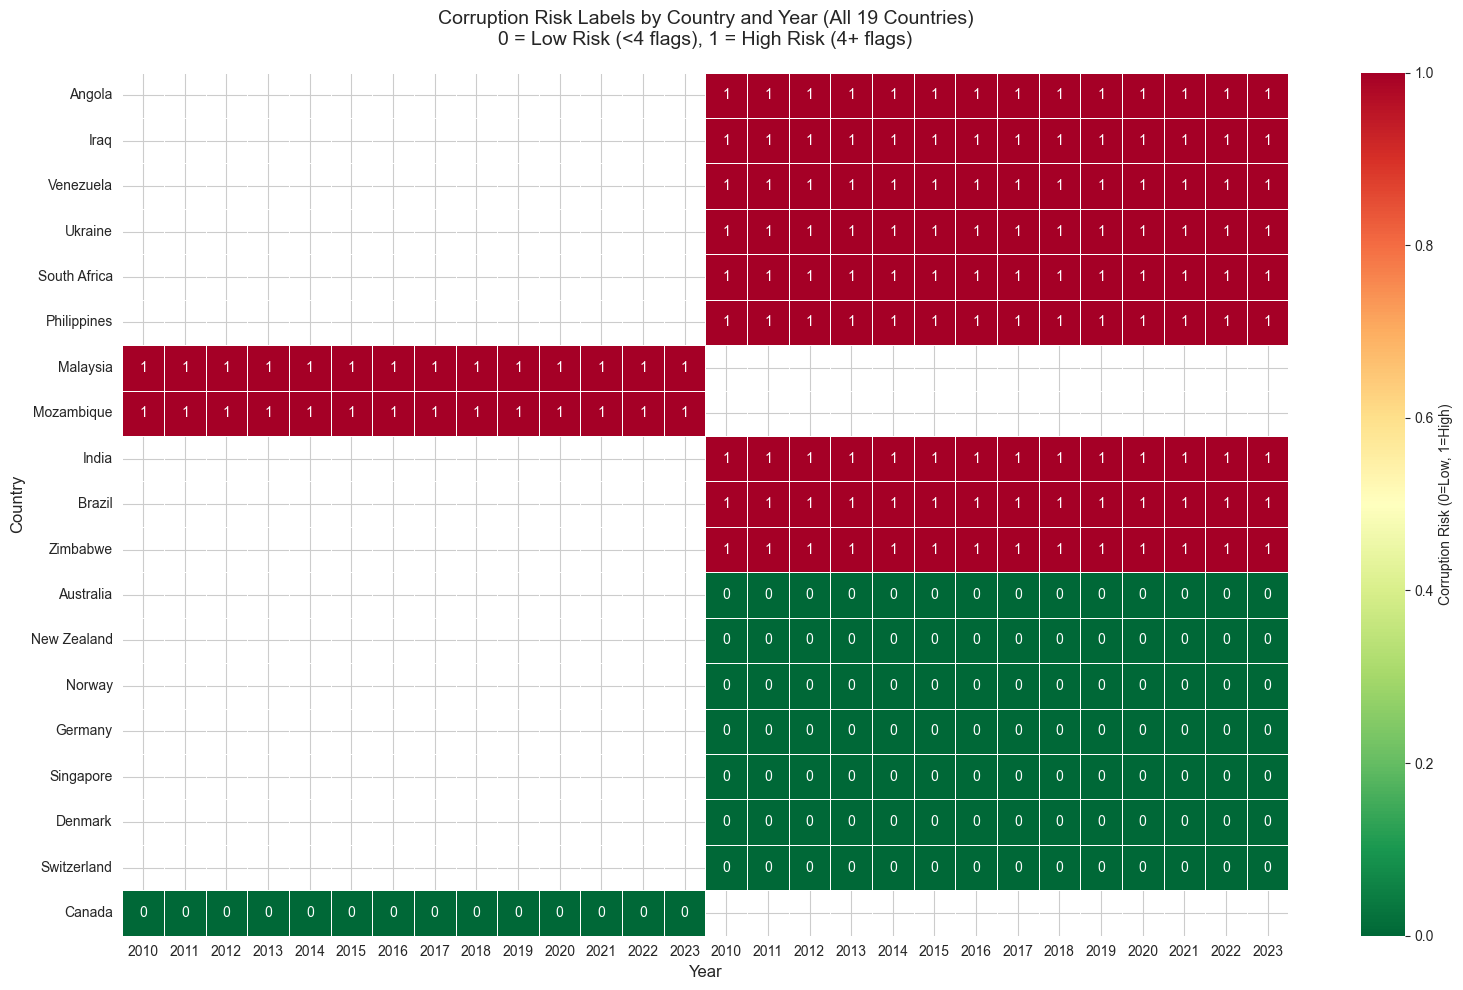

In [ ]:
# create heatmap showing corruption risk labels for all 19 countries over time
pivot_risk = df_expanded.pivot_table(index='Country', columns='Year', values='corruption_risk')

# sort by average risk (highest risk at top)
pivot_risk = pivot_risk.loc[pivot_risk.mean(axis=1).sort_values(ascending=False).index]

plt.figure(figsize=(16, 10))
sns.heatmap(pivot_risk, annot=True, fmt='.0f', cmap='RdYlGn_r', 
            cbar_kws={'label': 'Corruption Risk (0=Low, 1=High)'}, 
            linewidths=0.5, vmin=0, vmax=1)
plt.title('Corruption Risk Labels by Country and Year (All 19 Countries)\n0 = Low Risk (<4 flags), 1 = High Risk (4+ flags)', 
          fontsize=14, pad=20)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.savefig('results/figures/03/expanded_corruption_risk_labels_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()


## Save Labeled Expanded Dataset

Save the complete labeled dataset to use for model training


In [ ]:
# save to processed directory  
os.makedirs('data/processed', exist_ok=True)
output_path = 'data/processed/corruption_data_expanded_labeled.csv'
df_expanded.to_csv(output_path, index=False)

print(f"Saved labeled dataset to: {output_path}")
print(f"\nFinal dataset shape: {df_expanded.shape}")
print(f"Columns: {len(df_expanded.columns)}")
print(f"\nColumn names:")
print(df_expanded.columns.tolist())

print(f"\n\n=== FINAL SUMMARY ===")
print(f"Total observations: {len(df_expanded)} country-years")
print(f"Countries: {df_expanded['Country'].nunique()}")

# convert Year to numeric to avoid type comparison errors
year_numeric = pd.to_numeric(df_expanded['Year'], errors='coerce')
print(f"Years: {int(year_numeric.min())} - {int(year_numeric.max())}")

print(f"\nRisk Distribution:")
print(f"  Low Risk (0): {(df_expanded['corruption_risk'] == 0).sum()} ({(df_expanded['corruption_risk'] == 0).mean():.1%})")
print(f"  High Risk (1): {(df_expanded['corruption_risk'] == 1).sum()} ({(df_expanded['corruption_risk'] == 1).mean():.1%})")


Saved labeled dataset to: data/processed/corruption_data_expanded_labeled.csv

Final dataset shape: (266, 22)
Columns: 22

Column names:
['Political_Stability', 'FDI_Inflows_perc_GDP', 'Rule_of_Law', 'External_Debt_perc_GNI', 'Country', 'GDP_Growth_annual_perc', 'Govt_Expenditure_perc_GDP', 'Regulatory_Quality', 'Poverty_Headcount_Ratio', 'Government_Effectiveness', 'Voice_Accountability', 'Year', 'Control_of_Corruption', 'Risk_Category', 'Voice_Accountability_flag', 'Political_Stability_flag', 'Government_Effectiveness_flag', 'Regulatory_Quality_flag', 'Rule_of_Law_flag', 'Control_of_Corruption_flag', 'total_flags', 'corruption_risk']


=== FINAL SUMMARY ===
Total observations: 266 country-years
Countries: 19
Years: 2010 - 2023

Risk Distribution:
  Low Risk (0): 112 (42.1%)
  High Risk (1): 154 (57.9%)
